In [3]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Embedding,Dense,Dropout,GRU, LSTM
from keras.models import Sequential
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
# Train-Test
from sklearn.model_selection import train_test_split
# Scaling data
from sklearn.preprocessing import StandardScaler
# Classification Report
from sklearn.metrics import classification_report

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
combined = pd.read_csv('../../tmp/sentence_based_data_300K.csv')
combined.head()

,text,target
0,"Thereby, the return oil is prevented from goin...",1
1,"', 'While the present inventors examined impro...",0
2,"For example, the inner core portion and the ou...",0
3,"In a case where the traffic amount is small, w...",2
4,"', 'In the twelfth aspect of the invention, ac...",0


Prepare input data

In [6]:
y = combined["target"]

In [7]:
y_cat = to_categorical(y)

In [8]:
texts = combined.text.values

In [9]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(texts)

In [10]:
max_len = 512

In [11]:
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=512)

In [12]:
data.shape

(300000, 512)

In [13]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,y_cat,test_size=0.2,random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=101)

In [14]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

240000
30000
30000


In [15]:
word_index = tokenizer.word_index

In [16]:
GLOVE_FILE = 'C:/Study/glove.6B.100d.txt'
f = open(GLOVE_FILE,'r',encoding="utf8")

In [17]:
embeddings_index = {}
import numpy as np
for line in f:
  values = line.split()
  word = values[0]
  embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [18]:
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Normal model

In [19]:
# from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix],trainable=False))

model.add(LSTM(units=128,dropout = 0.5,recurrent_dropout = 0.2))

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3,activation="softmax"))
# output model skeleton
opt = Adam(learning_rate = 0.005)
model.summary()
model.compile(optimizer= opt , loss ='categorical_crossentropy',metrics=['accuracy'])
plot_model(model, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         5669600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [20]:
model.fit(X_train, y_train, verbose=1, epochs=2)

Epoch 1/2
  21/7500 [..............................] - ETA: 2:34:08 - loss: 1.1110 - accuracy: 0.3333

KeyboardInterrupt: 

In [26]:
model.evaluate(X_test, y_test)

938/938 [==============================] - 68s 72ms/step - loss: 0.7037 - accuracy: 0.7117


[0.7037455439567566, 0.7116666436195374]

In [27]:
y_pred = model.predict(X_test)

938/938 [==============================] - 69s 73ms/step


In [28]:
print(y_pred.shape)
print(y_test.shape)

(30000, 3)
(30000, 3)


In [29]:
y_pred = (y_pred > 0.5)

In [30]:
y_pred[0]

array([False,  True, False])

In [31]:
print((classification_report(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.76      0.59      0.67      9993
           1       0.79      0.53      0.63     10051
           2       0.84      0.62      0.71      9956

   micro avg       0.80      0.58      0.67     30000
   macro avg       0.80      0.58      0.67     30000
weighted avg       0.80      0.58      0.67     30000
 samples avg       0.58      0.58      0.58     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sequential model LSTM

Without using glove embeddings

In [21]:
len(word_index)

56695

In [22]:
model1 = Sequential()
# model1.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix]))
model1.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
# model1.add(Embedding(max_words, 20))
model1.add(LSTM(64,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

model1.summary()
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
plot_model(model1, to_file='dl_model_lstm_wo_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model1, to_file='dl_model_lstm_wo_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 5,712,035
Trainable params: 5,712,035
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
# history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])
history_1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 1585s 211ms/step - loss: 0.6098 - accuracy: 0.7525 - val_loss: 0.5537 - val_accuracy: 0.7785
Epoch 2/10
7500/7500 [==============================] - 1295s 173ms/step - loss: 0.5232 - accuracy: 0.7911 - val_loss: 0.5063 - val_accuracy: 0.7987
Epoch 3/10
7500/7500 [==============================] - 1269s 169ms/step - loss: 0.4928 - accuracy: 0.8049 - val_loss: 0.4833 - val_accuracy: 0.8088
Epoch 4/10
7500/7500 [==============================] - 1332s 178ms/step - loss: 0.4725 - accuracy: 0.8144 - val_loss: 0.4823 - val_accuracy: 0.8117
Epoch 5/10
7500/7500 [==============================] - 1369s 183ms/step - loss: 0.4580 - accuracy: 0.8217 - val_loss: 0.4717 - val_accuracy: 0.8161
Epoch 6/10
7500/7500 [==============================] - 1345s 179ms/step - loss: 0.4459 - accuracy: 0.8270 - val_loss: 0.4706 - val_accuracy: 0.8159
Epoch 7/10
7500/7500 [==============================] - 1319s 176ms/step - loss: 0.4381 - accuracy: 0.8310

In [24]:
a = len(history_1.history["loss"])

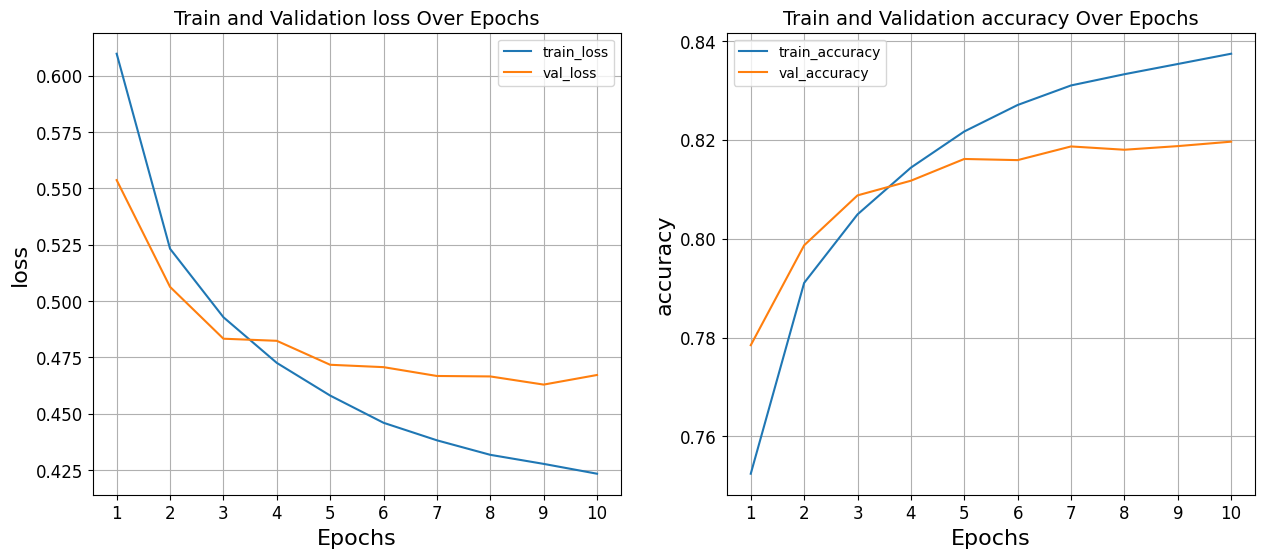

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_lstm_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_lstm_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [26]:
model1.evaluate(X_test, y_test)

938/938 [==============================] - 53s 57ms/step - loss: 0.4683 - accuracy: 0.8199


[0.4683351516723633, 0.8198666572570801]

In [27]:
y_pred_1 = model1.predict(X_test)

938/938 [==============================] - 55s 58ms/step


In [28]:
y_pred_1 = (y_pred_1 > 0.5)

In [29]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      9993
           1       0.82      0.78      0.80     10051
           2       0.87      0.86      0.86      9956

   micro avg       0.84      0.80      0.82     30000
   macro avg       0.84      0.80      0.82     30000
weighted avg       0.84      0.80      0.82     30000
 samples avg       0.80      0.80      0.80     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the glove embeddings

In [30]:
len(word_index)

56695

In [31]:
model1 = Sequential()
model1.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
# model1.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
# model1.add(Embedding(max_words, 20))
model1.add(LSTM(64,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

model1.summary()
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#plot_model(model1, to_file='dl_model_lstm_w_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model1, to_file='dl_model_lstm_w_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 5,712,035
Trainable params: 42,435
Non-trainable params: 5,669,600
_________________________________________________________________


In [32]:
# history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])
history_1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 1104s 147ms/step - loss: 0.7654 - accuracy: 0.6579 - val_loss: 0.6123 - val_accuracy: 0.7437
Epoch 2/10
7500/7500 [==============================] - 1117s 149ms/step - loss: 0.6179 - accuracy: 0.7398 - val_loss: 0.5480 - val_accuracy: 0.7783
Epoch 3/10
7500/7500 [==============================] - 1151s 153ms/step - loss: 0.5849 - accuracy: 0.7565 - val_loss: 0.5288 - val_accuracy: 0.7843
Epoch 4/10
7500/7500 [==============================] - 1120s 149ms/step - loss: 0.5690 - accuracy: 0.7651 - val_loss: 0.5297 - val_accuracy: 0.7832
Epoch 5/10
7500/7500 [==============================] - 1218s 162ms/step - loss: 0.5577 - accuracy: 0.7688 - val_loss: 0.5127 - val_accuracy: 0.7928
Epoch 6/10
7500/7500 [==============================] - 1209s 161ms/step - loss: 0.5520 - accuracy: 0.7731 - val_loss: 0.5153 - val_accuracy: 0.7915
Epoch 7/10
7500/7500 [==============================] - 1179s 157ms/step - loss: 0.5458 - accuracy: 0.7758

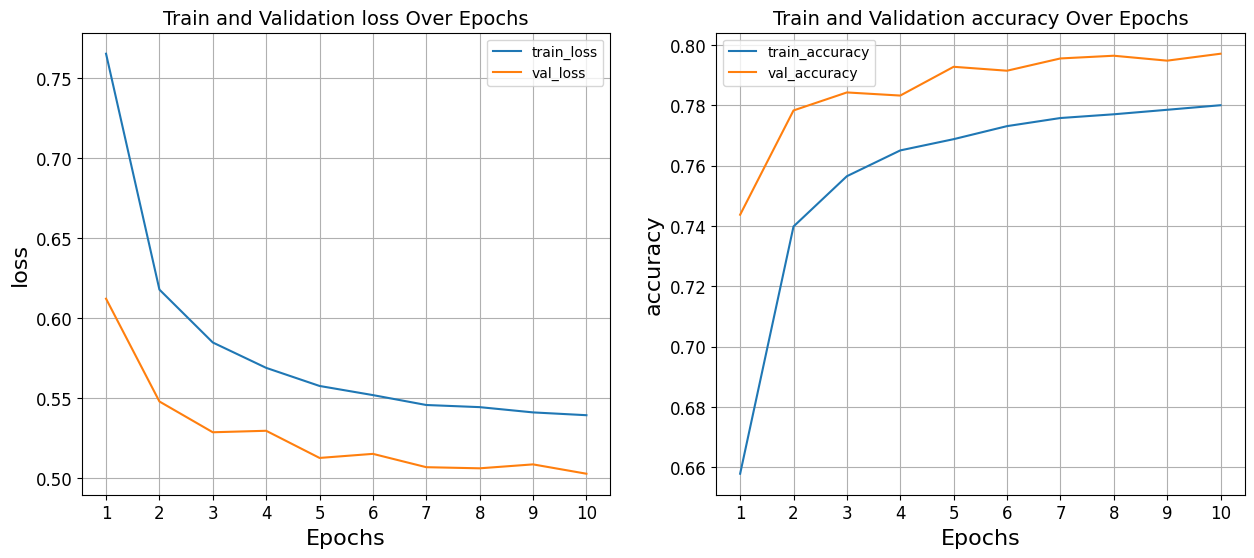

In [33]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1),fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_lstm_w_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_lstm_w_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [34]:
model1.evaluate(X_test, y_test)

938/938 [==============================] - 57s 60ms/step - loss: 0.5034 - accuracy: 0.7943


[0.5034154653549194, 0.7943000197410583]

In [36]:
y_pred_1 = model1.predict(X_test)

938/938 [==============================] - 56s 60ms/step


In [37]:
y_pred_1 = (y_pred_1 > 0.5)

In [38]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      9993
           1       0.81      0.75      0.78     10051
           2       0.84      0.84      0.84      9956

   micro avg       0.83      0.76      0.79     30000
   macro avg       0.83      0.76      0.79     30000
weighted avg       0.83      0.76      0.79     30000
 samples avg       0.76      0.76      0.76     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
print(len(word_index))

56695


Sequential model Bi-LSTM

Withouht glove embeddings

In [40]:
model2 = Sequential()
model2.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(10,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()
plot_model(model2, to_file='dl_model_bilstm_wo_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model2, to_file='dl_model_bilstm_wo_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 bidirectional (Bidirectiona  (None, 20)               8880      
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 3)                 63        
                                                                 
Total params: 5,678,543
Trainable params: 5,678,543
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https:

In [41]:
history_2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 1072s 143ms/step - loss: 0.6436 - accuracy: 0.7381 - val_loss: 0.5704 - val_accuracy: 0.7749
Epoch 2/10
7500/7500 [==============================] - 995s 133ms/step - loss: 0.5649 - accuracy: 0.7749 - val_loss: 0.5537 - val_accuracy: 0.7817
Epoch 3/10
7500/7500 [==============================] - 1110s 148ms/step - loss: 0.5403 - accuracy: 0.7847 - val_loss: 0.5393 - val_accuracy: 0.7874
Epoch 4/10
7500/7500 [==============================] - 1085s 145ms/step - loss: 0.5241 - accuracy: 0.7926 - val_loss: 0.5143 - val_accuracy: 0.7955
Epoch 5/10
7500/7500 [==============================] - 1026s 137ms/step - loss: 0.5136 - accuracy: 0.7973 - val_loss: 0.5205 - val_accuracy: 0.7974
Epoch 6/10
7500/7500 [==============================] - 1184s 158ms/step - loss: 0.5053 - accuracy: 0.8006 - val_loss: 0.5083 - val_accuracy: 0.8006
Epoch 7/10
7500/7500 [==============================] - 1007s 134ms/step - loss: 0.4980 - accuracy: 0.8041 

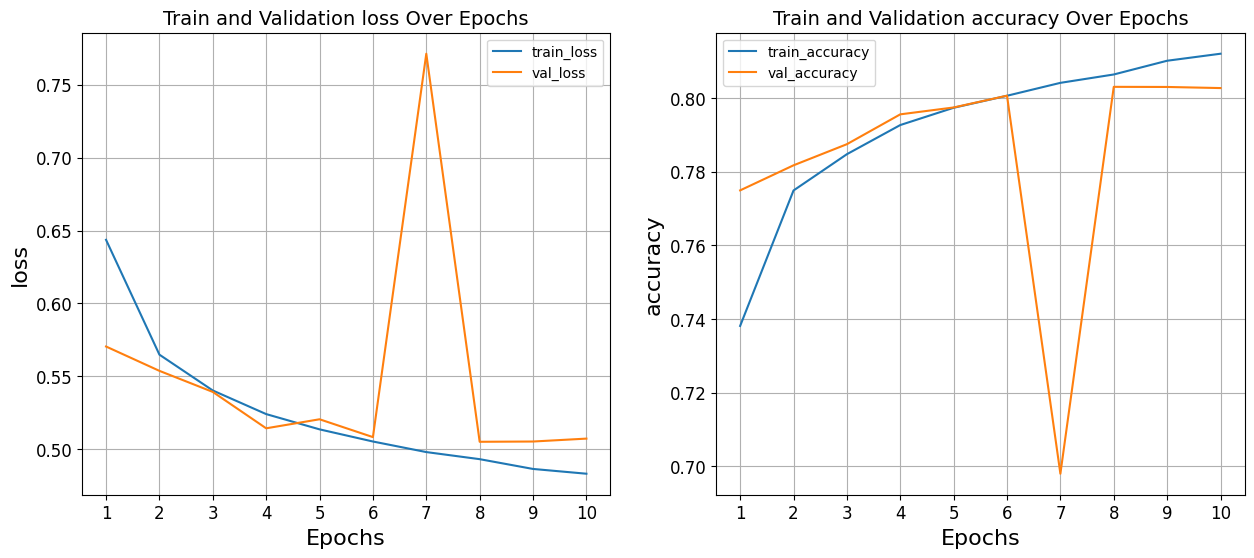

In [42]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_2.history["loss"], label="train_loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_2.history["accuracy"], label="train_accuracy")
plt.plot(history_2.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_bilstm_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_bilstm_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [43]:
model2.evaluate(X_test, y_test)

938/938 [==============================] - 33s 36ms/step - loss: 0.5085 - accuracy: 0.8016


[0.5084512233734131, 0.8015999794006348]

In [44]:
y_pred_2 = model2.predict(X_test)

938/938 [==============================] - 33s 35ms/step


In [45]:
y_pred_2 = (y_pred_2 > 0.5)

In [46]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      9993
           1       0.82      0.74      0.78     10051
           2       0.85      0.85      0.85      9956

   micro avg       0.82      0.78      0.80     30000
   macro avg       0.82      0.78      0.80     30000
weighted avg       0.82      0.78      0.80     30000
 samples avg       0.78      0.78      0.78     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With glove embeddings

In [47]:
model2 = Sequential()
model2.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model2.add(layers.Bidirectional(layers.LSTM(10,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()
#plot_model(model2, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model2_w_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model2, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model2_w_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               8880      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 3)                 63        
                                                                 
Total params: 5,678,543
Trainable params: 8,943
Non-trainable params: 5,669,600
_________________________________________________________________


In [48]:
history_2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 785s 104ms/step - loss: 0.9218 - accuracy: 0.5630 - val_loss: 0.7465 - val_accuracy: 0.6828
Epoch 2/10
7500/7500 [==============================] - 783s 104ms/step - loss: 0.7968 - accuracy: 0.6469 - val_loss: 0.7214 - val_accuracy: 0.6859
Epoch 3/10
7500/7500 [==============================] - 785s 105ms/step - loss: 0.7635 - accuracy: 0.6634 - val_loss: 0.6864 - val_accuracy: 0.7055
Epoch 4/10
7500/7500 [==============================] - 784s 105ms/step - loss: 0.7439 - accuracy: 0.6741 - val_loss: 0.6597 - val_accuracy: 0.7191
Epoch 5/10
7500/7500 [==============================] - 783s 104ms/step - loss: 0.7307 - accuracy: 0.6810 - val_loss: 0.6742 - val_accuracy: 0.7060
Epoch 6/10
7500/7500 [==============================] - 783s 104ms/step - loss: 0.7228 - accuracy: 0.6861 - val_loss: 0.6468 - val_accuracy: 0.7266
Epoch 7/10
7500/7500 [==============================] - 785s 105ms/step - loss: 0.7147 - accuracy: 0.6900 - val_

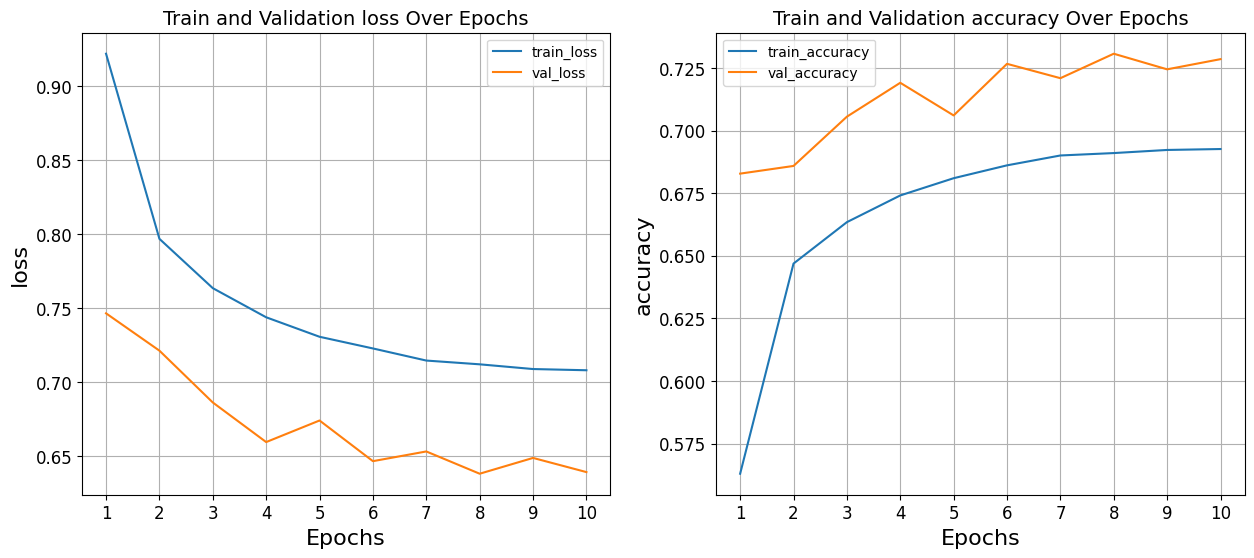

In [49]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_2.history["loss"], label="train_loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_2.history["accuracy"], label="train_accuracy")
plt.plot(history_2.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_bilstm_w_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_bilstm_w_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [50]:
model2.evaluate(X_test, y_test)

938/938 [==============================] - 32s 35ms/step - loss: 0.6422 - accuracy: 0.7295


[0.6421726942062378, 0.7294999957084656]

In [51]:
y_pred_2 = model2.predict(X_test)

938/938 [==============================] - 34s 35ms/step


In [52]:
y_pred_2 = (y_pred_2 > 0.5)

In [53]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.73      0.67      0.69      9993
           1       0.79      0.61      0.69     10051
           2       0.86      0.65      0.74      9956

   micro avg       0.79      0.64      0.71     30000
   macro avg       0.79      0.64      0.71     30000
weighted avg       0.79      0.64      0.71     30000
 samples avg       0.64      0.64      0.64     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sequential 1d-CNN

without glove embedding

In [54]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()
# checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])
plot_model(model3, to_file='dl_model_cnn_wo_annoo_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model3, to_file='dl_model_cnn_wo_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 conv1d (Conv1D)             (None, 507, 20)           12020     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 101, 20)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 20)            2420      
                                                                 
 global_max_pooling1d (Globa  (None, 20)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_9 (Dense)             (None, 3)                

In [55]:
history_3 = model3.fit(X_train, y_train, validation_data=(X_val,y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 285s 38ms/step - loss: 1.1195 - accuracy: 0.3340 - val_loss: 1.1133 - val_accuracy: 0.3328
Epoch 2/10
7500/7500 [==============================] - 285s 38ms/step - loss: 1.1132 - accuracy: 0.3320 - val_loss: 1.1131 - val_accuracy: 0.3314
Epoch 3/10
7500/7500 [==============================] - 272s 36ms/step - loss: 1.0235 - accuracy: 0.4632 - val_loss: 0.8740 - val_accuracy: 0.6284
Epoch 4/10
7500/7500 [==============================] - 272s 36ms/step - loss: 0.8181 - accuracy: 0.6612 - val_loss: 0.7925 - val_accuracy: 0.6763
Epoch 5/10
7500/7500 [==============================] - 272s 36ms/step - loss: 0.7794 - accuracy: 0.6805 - val_loss: 0.7730 - val_accuracy: 0.6804
Epoch 6/10
7500/7500 [==============================] - 272s 36ms/step - loss: 0.7612 - accuracy: 0.6898 - val_loss: 0.7866 - val_accuracy: 0.6813
Epoch 7/10
7500/7500 [==============================] - 312s 42ms/step - loss: 0.7493 - accuracy: 0.6966 - val_loss: 0

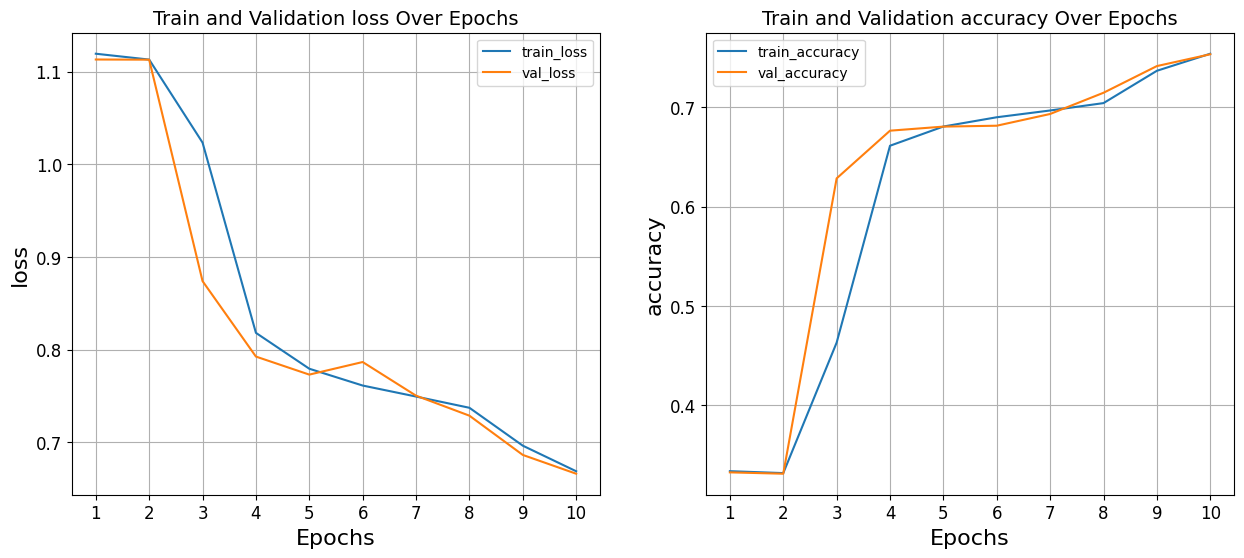

In [56]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_3.history["loss"], label="train_loss")
plt.plot(history_3.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_3.history["accuracy"], label="train_accuracy")
plt.plot(history_3.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_cnn_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_cnn_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [57]:
model3.evaluate(X_test, y_test)

938/938 [==============================] - 7s 7ms/step - loss: 0.6678 - accuracy: 0.7536


[0.6678482890129089, 0.7535666823387146]

In [58]:
y_pred_3 = model3.predict(X_test)

938/938 [==============================] - 7s 7ms/step


In [59]:
y_pred_3 = (y_pred_3 > 0.5)

In [60]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.77      0.68      0.73      9993
           1       0.79      0.65      0.71     10051
           2       0.84      0.74      0.79      9956

   micro avg       0.80      0.69      0.74     30000
   macro avg       0.80      0.69      0.74     30000
weighted avg       0.80      0.69      0.74     30000
 samples avg       0.69      0.69      0.69     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


with glove embedding

In [61]:
from keras import regularizers
model3 = Sequential()
model3.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()
# checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])
#plot_model(model3, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model3_w_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model3, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model3_w_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 conv1d_2 (Conv1D)           (None, 507, 20)           12020     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 101, 20)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 20)            2420      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 3)                

In [62]:
history_3 = model3.fit(X_train, y_train, validation_data=(X_val,y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 174s 23ms/step - loss: 0.9679 - accuracy: 0.6531 - val_loss: 0.8694 - val_accuracy: 0.6830
Epoch 2/10
7500/7500 [==============================] - 173s 23ms/step - loss: 0.8646 - accuracy: 0.6881 - val_loss: 0.8569 - val_accuracy: 0.6876
Epoch 3/10
7500/7500 [==============================] - 163s 22ms/step - loss: 0.8546 - accuracy: 0.6898 - val_loss: 0.9616 - val_accuracy: 0.6367
Epoch 4/10
7500/7500 [==============================] - 167s 22ms/step - loss: 0.8504 - accuracy: 0.6907 - val_loss: 0.8314 - val_accuracy: 0.6981
Epoch 5/10
7500/7500 [==============================] - 166s 22ms/step - loss: 0.8471 - accuracy: 0.6902 - val_loss: 0.8624 - val_accuracy: 0.6804
Epoch 6/10
7500/7500 [==============================] - 157s 21ms/step - loss: 0.8454 - accuracy: 0.6921 - val_loss: 0.8289 - val_accuracy: 0.7010
Epoch 7/10
7500/7500 [==============================] - 157s 21ms/step - loss: 0.8436 - accuracy: 0.6917 - val_loss: 0

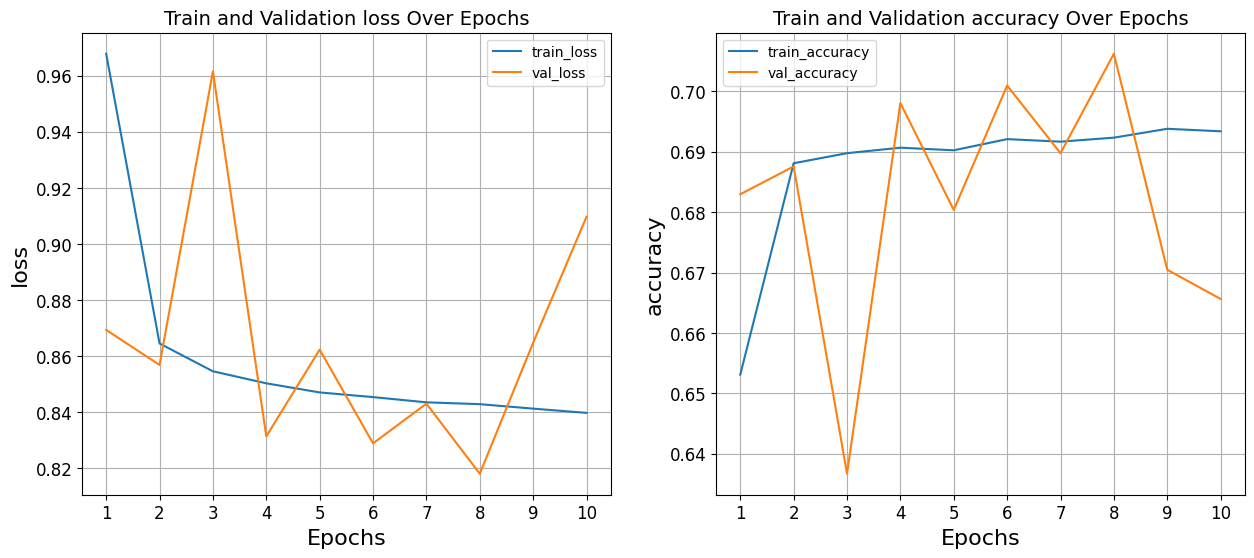

In [63]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_3.history["loss"], label="train_loss")
plt.plot(history_3.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_3.history["accuracy"], label="train_accuracy")
plt.plot(history_3.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_cnn_w_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_cnn_w_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [64]:
model3.evaluate(X_test, y_test)

938/938 [==============================] - 6s 6ms/step - loss: 0.9130 - accuracy: 0.6623


[0.9129951596260071, 0.6622999906539917]

In [65]:
y_pred_3 = model3.predict(X_test)

938/938 [==============================] - 6s 6ms/step


In [66]:
y_pred_3 = (y_pred_3 > 0.5)

In [67]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.74      0.55      0.63      9993
           1       0.88      0.38      0.53     10051
           2       0.65      0.84      0.73      9956

   micro avg       0.71      0.59      0.64     30000
   macro avg       0.76      0.59      0.63     30000
weighted avg       0.76      0.59      0.63     30000
 samples avg       0.59      0.59      0.59     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sequential model GRU

Without glove embedding

In [68]:
model4 = Sequential()
model4.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
model4.add(layers.GRU(20,dropout=0.6, activation='relu'))
model4.add(layers.Dense(3,activation='softmax'))
model4.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()
plot_model(model4, to_file='dl_model_gru_wo_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model4, to_file='dl_model_gru_wo_anno_wo_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 gru (GRU)                   (None, 20)                7320      
                                                                 
 dense_11 (Dense)            (None, 3)                 63        
                                                                 
Total params: 5,676,983
Trainable params: 5,676,983
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [69]:
history_4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 762s 101ms/step - loss: 0.6371 - accuracy: 0.7328 - val_loss: 0.5568 - val_accuracy: 0.7760
Epoch 2/10
7500/7500 [==============================] - 764s 102ms/step - loss: 0.5458 - accuracy: 0.7812 - val_loss: 0.5223 - val_accuracy: 0.7896
Epoch 3/10
7500/7500 [==============================] - 762s 102ms/step - loss: 0.5282 - accuracy: 0.7891 - val_loss: 0.5174 - val_accuracy: 0.7930
Epoch 4/10
7500/7500 [==============================] - 762s 102ms/step - loss: 0.5203 - accuracy: 0.7944 - val_loss: 0.5077 - val_accuracy: 0.7973
Epoch 5/10
7500/7500 [==============================] - 761s 101ms/step - loss: 0.5148 - accuracy: 0.7968 - val_loss: 0.5080 - val_accuracy: 0.8000
Epoch 6/10
7500/7500 [==============================] - 762s 102ms/step - loss: 0.5105 - accuracy: 0.7990 - val_loss: 0.5095 - val_accuracy: 0.8026
Epoch 7/10
7500/7500 [==============================] - 766s 102ms/step - loss: 0.5067 - accuracy: 0.8009 - val_

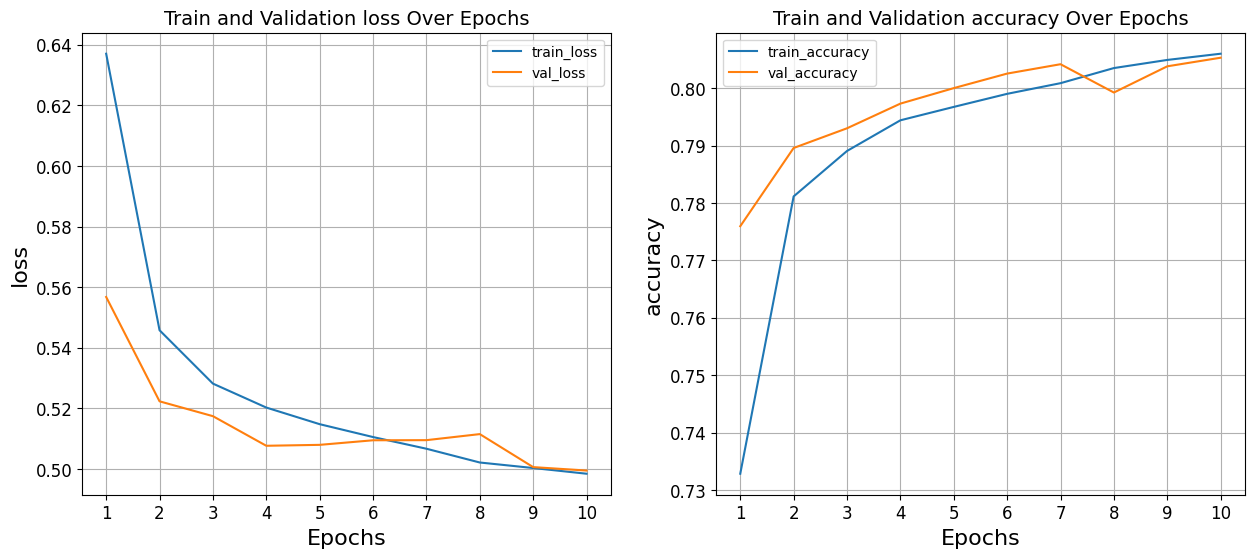

In [70]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_4.history["loss"], label="train_loss")
plt.plot(history_4.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_4.history["accuracy"], label="train_accuracy")
plt.plot(history_4.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_gru_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_gru_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [71]:
model4.evaluate(X_test, y_test)

938/938 [==============================] - 25s 27ms/step - loss: 0.5057 - accuracy: 0.8001


[0.5057011842727661, 0.8000666499137878]

In [72]:
y_pred_4 = model4.predict(X_test)

938/938 [==============================] - 25s 27ms/step


In [73]:
y_pred_4 = (y_pred_4 > 0.5)

In [74]:
print(classification_report(y_test,y_pred_4))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      9993
           1       0.81      0.76      0.78     10051
           2       0.84      0.84      0.84      9956

   micro avg       0.83      0.77      0.80     30000
   macro avg       0.83      0.77      0.80     30000
weighted avg       0.83      0.77      0.80     30000
 samples avg       0.77      0.77      0.77     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With glove embedding

In [75]:
model4 = Sequential()
model4.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model4.add(layers.GRU(20,dropout=0.6, activation='relu'))
model4.add(layers.Dense(3,activation='softmax'))
model4.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()
#plot_model(model4, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model4_anno_w_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model4, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model4_anno_w_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 gru_1 (GRU)                 (None, 20)                7320      
                                                                 
 dense_12 (Dense)            (None, 3)                 63        
                                                                 
Total params: 5,676,983
Trainable params: 7,383
Non-trainable params: 5,669,600
_________________________________________________________________


In [76]:
history_4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 634s 84ms/step - loss: 0.8504 - accuracy: 0.6043 - val_loss: 0.6944 - val_accuracy: 0.6985
Epoch 2/10
7500/7500 [==============================] - 631s 84ms/step - loss: 0.7225 - accuracy: 0.6852 - val_loss: 0.6441 - val_accuracy: 0.7296
Epoch 3/10
7500/7500 [==============================] - 632s 84ms/step - loss: 0.6975 - accuracy: 0.6990 - val_loss: 0.6261 - val_accuracy: 0.7373
Epoch 4/10
7500/7500 [==============================] - 633s 84ms/step - loss: 0.6868 - accuracy: 0.7056 - val_loss: 0.6264 - val_accuracy: 0.7341
Epoch 5/10
7500/7500 [==============================] - 634s 85ms/step - loss: 0.6779 - accuracy: 0.7092 - val_loss: 0.6152 - val_accuracy: 0.7412
Epoch 6/10
7500/7500 [==============================] - 635s 85ms/step - loss: 0.6719 - accuracy: 0.7131 - val_loss: 0.6112 - val_accuracy: 0.7419
Epoch 7/10
7500/7500 [==============================] - 632s 84ms/step - loss: 0.6686 - accuracy: 0.7146 - val_loss: 0

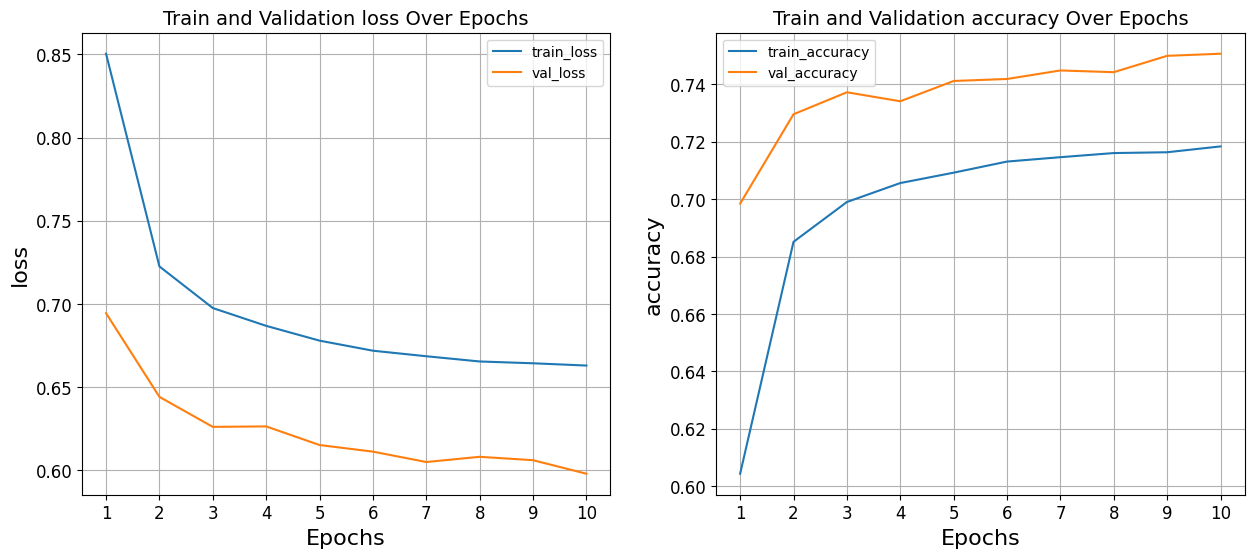

In [77]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_4.history["loss"], label="train_loss")
plt.plot(history_4.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_4.history["accuracy"], label="train_accuracy")
plt.plot(history_4.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_4_gru_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_4_gru_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [78]:
model4.evaluate(X_test, y_test)

938/938 [==============================] - 25s 27ms/step - loss: 0.5997 - accuracy: 0.7486


[0.5997234582901001, 0.7485666871070862]

In [79]:
y_pred_4 = model4.predict(X_test)

938/938 [==============================] - 25s 27ms/step


In [80]:
y_pred_4 = (y_pred_4 > 0.5)

In [81]:
print(classification_report(y_test,y_pred_4))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69      9993
           1       0.79      0.66      0.72     10051
           2       0.79      0.81      0.80      9956

   micro avg       0.80      0.69      0.74     30000
   macro avg       0.80      0.69      0.74     30000
weighted avg       0.80      0.69      0.74     30000
 samples avg       0.69      0.69      0.69     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Further Evaluation and Graphs

In [82]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

NameError: name 'best_model' is not defined

In [ ]:
predictions = model1.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})